### Interview Use-Case: Nathaniel Casanova ###
**Problem Statement:** <br>
Add/modify the codes to set S3 emissions to zero when the company REVENUE is set as the company value.

**Development Process:** <br>
The  tool was cloned from its Github repository to a local directory, and was installed in a conda environment using ```pip install -e .``` for development and testing. Dependencies were installed using poetry. Changes to the code were done locally and code versions were tracked using git. The codebase was unit tested using the nose2 framework test scripts provided by the tool developers. The revised codebase were then uploaded to a personal Github repository. Forking the tool was avoided as the changes were not intended to be merged with the tool's codebase.

**Discussion:** <br>
The problem statement mentioned will impact the ROTS Portfolio Aggregation Method in the SBTi Finance Tool since it uses REVENUE as the company value. The ROTS method aggregates temperature scores (TS) using the formula below:

$$ \sum_{n}^i \left(\left(\frac{\frac{\text{Investment value}_i}{\text{Company Revenue}}\times{\text{Company emissions}_i}}{\text{Total Revenue owned Emissions}}\right)\times{TS_i}\right) $$

The tool provides Temperature Scores for the following scope combinations: S1S2, S3, and S1S2S3. $\text{Company emissions}$ in the formula above will compose of the same scopes also as defined by the user. When S3 emissions is zero, it has the following effect on S1S2, S3, and S1S2S3 scopes:
- S1S2: No impact
- S3: ROTS can lead to NaN results for other calculations performed by the tool, since $\text{Company emissions} = 0$ and $\text{Total Revenue owned Emissions} = 0 $
- S1S2S3: Weights will be effectively determined only by S1S2, since S3 = 0. However, $TS$ still covers S1S2S3. This might potentially confuse users since the weights and the $TS$ doesn't effectively cover the same scope.

**Solution:** <br>
The solution to the problem statement will be elaborated  in the succeeding cells in this notebook. As a summary, listed below are references to the code modifications to address the problem statement. Kindly click on the links to open the modified scripts in Github.
-  [temperature_score.py](https://github.com/nates27/sbtif/blob/dev/SBTi/temperature_score.py), lines 630-643.
-  [temperature_score.py](https://github.com/nates27/sbtif/blob/dev/SBTi/temperature_score.py), lines 645-652
-  [portfolio_aggregation.py](https://github.com/nates27/sbtif/blob/dev/SBTi/portfolio_aggregation.py), lines 176-178.

Importing the necessary packages

In [30]:
%load_ext autoreload
%autoreload 2
import SBTi
from SBTi.data.excel import ExcelProvider
from SBTi.portfolio_aggregation import PortfolioAggregationMethod
from SBTi.portfolio_coverage_tvp import PortfolioCoverageTVP
from SBTi.temperature_score import TemperatureScore, Scenario, ScenarioType, EngagementType
from SBTi.target_validation import TargetProtocol
from SBTi.interfaces import ETimeFrames, EScope
from examples.utils import collect_company_contributions, plot_grouped_statistics, anonymize, print_aggregations, \
    plot_grouped_heatmap, print_scenario_gain, print_grouped_scores, get_contributions_per_group
%aimport -pandas -warnings
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will use the sample data provider and portfolio included in the tool to illustrate the solution.

In [31]:
provider = ExcelProvider(path="data/data_provider_example.xlsx")
df_portfolio = pd.read_csv("data/example_portfolio.csv", encoding="iso-8859-1")
companies = SBTi.utils.dataframe_to_portfolio(df_portfolio)

In [32]:
temperature_score = TemperatureScore(time_frames=list(SBTi.interfaces.ETimeFrames), scopes=[EScope.S1S2, EScope.S3, EScope.S1S2S3])
amended_portfolio = temperature_score.calculate(data_providers=[provider], portfolio=companies)
scores_collection = {}

Status code from fetching the CTA file: 200, 200 = OK


The ```TemperatureScore.aggregrate_scores``` method is used to aggregate the temperature scores of a portolio. It ingests the dataframe generated from the ```TemperatureScore.calculate``` method which contains the company-level Temperature Scores.

To address the impact on scope S3, and S1S2S3, the ROTS aggregation was limited to S1S2 scope. This is done by modifying the ```TemperatureScore.aggregrate_scores``` method. This is reflected in the [temperature_score.py](https://github.com/nates27/sbtif/blob/dev/SBTi/temperature_score.py) script, lines 630-643.

To specifically address the problem statement, the ```TemperatureScore.aggregrate_scores``` method was further modified to return an additional datafame where all S3 emissions are set to zero when the aggregation method is ROTS. This method modifies the dataframe generated from the ```TemperatureScore.calculate``` method. This is reflected in the [temperature_score.py](https://github.com/nates27/sbtif/blob/dev/SBTi/temperature_score.py) script, lines 645-652.

Additionally, S3 emissions were also set to zero during the actual ROTS calculation. This is reflected in the  ```PortfolioAggregation._calculate_aggregate_score``` method in the [portfolio_aggregation.py](https://github.com/nates27/sbtif/blob/dev/SBTi/portfolio_aggregation.py) script, lines 176-178.

These modifications are illustrated below.

In [33]:
temperature_score.aggregation_method = PortfolioAggregationMethod.ROTS
aggregated_scores, modified_portfolio = temperature_score.aggregate_scores(amended_portfolio)
df_rots = pd.DataFrame(aggregated_scores.dict()).dropna().applymap(lambda x: round(x['all']['score'], 2))
scores_collection.update({'ROTS': df_rots})
df_rots

,short,mid,long
S1S2,3.09,3.12,3.1


In [34]:
modified_portfolio[['company_id', 'ghg_s3']]

,company_id,ghg_s3
0,US0079031078,0
1,US0079031078,0
2,US0079031078,0
3,US0079031078,0
4,US0079031078,0
...,...,...
436,ID0000000032,0
437,ID0000000032,0
438,ID0000000032,0
439,ID0000000032,0


In [35]:
print(f"Sum of S3 emissions in ROTS modified portfolio: {modified_portfolio['ghg_s3'].sum()}")

Sum of S3 emissions in ROTS modified portfolio: 0


The original dataframe generated from ```TemperatureScore.calculate``` method is preserved and can be reused to aggregate temperature scores using another portfolio aggregation method. Other aggregation methods still return a single output and can still cover both S3 and S1S2S3 scopes.

In [36]:
# Using ECOTS
print(f"Sum of S3 emissions in df from calculate function: {amended_portfolio['ghg_s3'].sum()}")
temperature_score.aggregation_method = PortfolioAggregationMethod.ECOTS
aggregated_scores = temperature_score.aggregate_scores(amended_portfolio)
df_ecots = pd.DataFrame(aggregated_scores.dict()).dropna().applymap(lambda x: round(x['all']['score'], 2))
scores_collection.update({'ECOTS': df_ecots})
df_ecots

Sum of S3 emissions in df from calculate function: 3064498105.4900894


,short,mid,long
S1S2,3.03,3.08,3.14
S3,3.19,2.43,3.21
S1S2S3,3.13,2.67,3.18


In [37]:
pd.concat(scores_collection, axis=0)

short   mid  long
ROTS  S1S2     3.09  3.12  3.10
ECOTS S1S2     3.03  3.08  3.14
      S3       3.19  2.43  3.21
      S1S2S3   3.13  2.67  3.18

### Sample Analysis ###

The following cells recreate some of the sample analysis provided in the other example notebooks using the ROTS aggregation method.

#### Regional and Sectoral Quick Analysis ####

In [38]:
time_frames = [ETimeFrames.MID]
scopes = [EScope.S1S2, EScope.S3, EScope.S1S2S3]
fallback_score = 3.2

temperature_score.aggregation_method = PortfolioAggregationMethod.ROTS
aggregated_portfolio = temperature_score.aggregate_scores(amended_portfolio)

grouping = ['sector', 'region']
temperature_score = TemperatureScore(
    time_frames=time_frames,
    scopes=scopes,
    grouping=grouping
)
grouped_portfolio = temperature_score.calculate(data_providers=[provider], portfolio=companies)
grouped_aggregations = temperature_score.aggregate_scores(grouped_portfolio)

Status code from fetching the CTA file: 200, 200 = OK


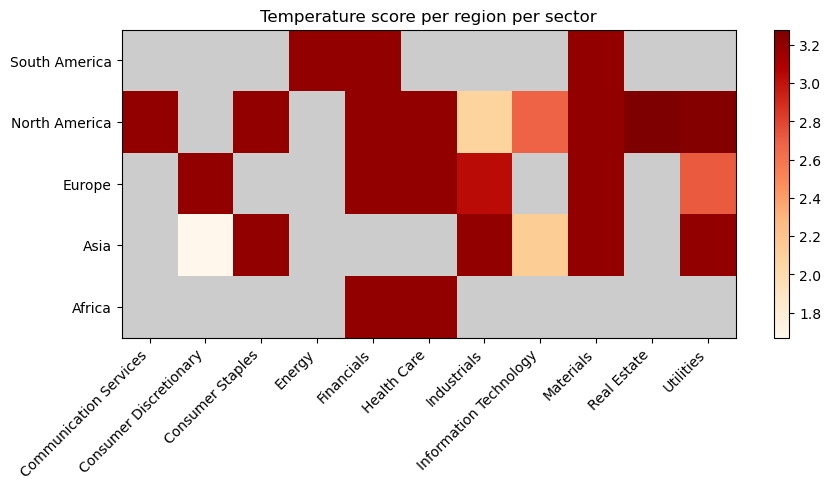

In [39]:
analysis_parameters = ([ETimeFrames.MID], [EScope.S1S2], grouping)
plot_grouped_heatmap(grouped_aggregations, analysis_parameters)

#### Sector Analysis ####

Status code from fetching the CTA file: 200, 200 = OK


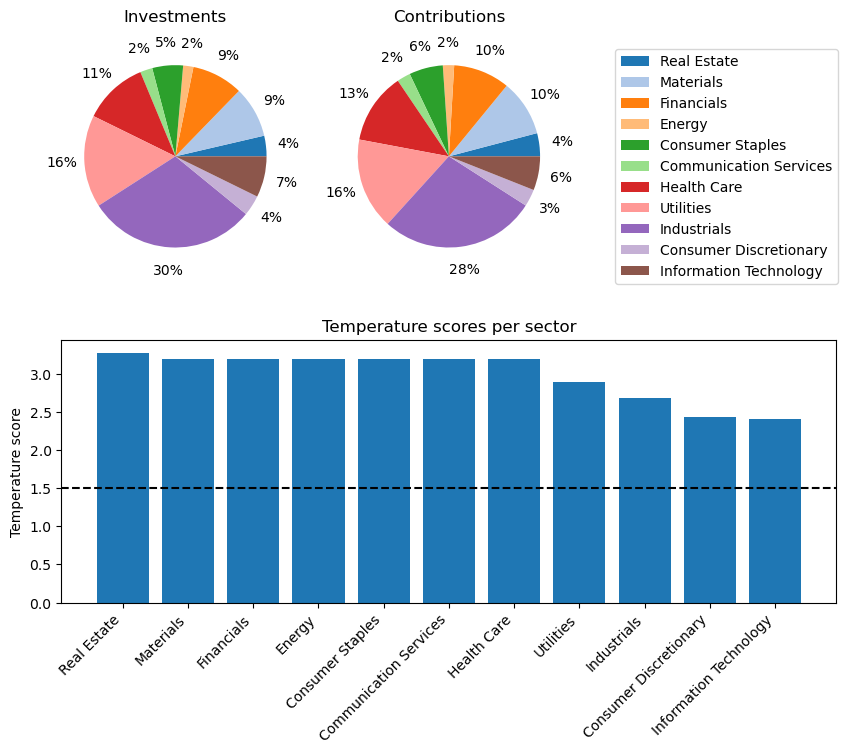

In [40]:
time_frames = [ETimeFrames.MID]
scopes = [EScope.S1S2]
grouping = ['sector']
analysis_parameters = (time_frames, scopes, grouping)

temperature_score = TemperatureScore(time_frames=time_frames,
                                     scopes=scopes,
                                     grouping=grouping)
amended_portfolio = temperature_score.calculate(data_providers=[provider], portfolio=companies)
aggregated_portfolio = temperature_score.aggregate_scores(amended_portfolio)
company_contributions = collect_company_contributions(aggregated_portfolio, amended_portfolio, analysis_parameters)

plot_grouped_statistics(aggregated_portfolio, company_contributions, analysis_parameters)